# Deel 1 : Productieproces

# A : nodige modules

In [38]:
# standaard in python
import os 
import datetime
import sys
import json

In [39]:
# te installeren packages en modules
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from scipy.stats import norm

import seaborn as sns

In [40]:
# eigen packages modules
current_working_directory = os.getcwd()                                    
parent_working_directory = os.path.dirname(current_working_directory)      
scripts_directory = os.path.join(parent_working_directory, 'scripts')      
sys.path.append(scripts_directory)                                         
# sys.path.remove(scripts_directory)
# print(sys.path)

import comeinhandy as cih
import simulatie as sim

# B : functies nog niet in modules

# C : opladen van de gegevens

In [41]:
# opladen JSON file met MSR waarden (min_sust_rate = minimu sustainable rate)
min_sust_rate_locatie = "../data/raw/productiemodel/data_productie/master_data.json"
df_msr_gegevens = cih.laad_msr_gegevens_in_dataframe(min_sust_rate_locatie)
# df_msr_gegevens

In [42]:
# bepaal waar de dagelijk productie sets (per fabriek) zich bevinden op schijf
dagelijkse_productie_locatie = "../data/raw/productiemodel/data_productie/daily_production/"

In [43]:
# Laad dagelijks productie voor BRU in BRU dataframe
factory = 'BRU'
dagelijkse_productie_BRU = cih.laad_dagelijkse_productie_in_dataframe(
                                factory, 
                                os.path.join(dagelijkse_productie_locatie, factory))
# dagelijkse_productie_BRU

# voeg MSR waarden toe op het STO dagelijkse productie dataframe
dagelijkse_productie_BRU = dagelijkse_productie_BRU.merge(
                                        df_msr_gegevens, on='factory', how='left')
# dagelijkse_productie_BRU

# verwijder records waar onderhoud werd gepland, zie opgave Deel 1, stap 5, bullet 1 en dixit Tim in de klas
dagelijkse_productie_BRU = dagelijkse_productie_BRU[dagelijkse_productie_BRU['maintenance'] == 'No']
# dagelijkse_productie_STO

In [44]:
# Laad dagelijks productie voor STO in STO dataframe
factory = 'STO'
dagelijkse_productie_STO = cih.laad_dagelijkse_productie_in_dataframe(
                                factory, 
                                os.path.join(dagelijkse_productie_locatie, factory))
# dagelijkse_productie_STO

# voeg MSR waarden toe op het STO dagelijkse productie dataframe
dagelijkse_productie_STO = dagelijkse_productie_STO.merge(
                                        df_msr_gegevens, on='factory', how='left')
# dagelijkse_productie_STO

# verwijder records waar onderhoud werd gepland, zie opgave Deel 1, stap 5, bullet 1 en dixit Tim in de klas
dagelijkse_productie_STO = dagelijkse_productie_STO[dagelijkse_productie_STO['maintenance'] == 'No']
# dagelijkse_productie_STO

In [45]:
# Breng alle gegevens te samen in een groot dataframe, in geval van analyse totaal productie
dagelijkse_productie_ALL = pd.concat(
                            [dagelijkse_productie_BRU, 
                             dagelijkse_productie_STO],
                               ignore_index=True)
#  save het voor analyse in een Excel sheet
dagelijkse_productie_ALL.to_excel("../data/interim/dagelijkse_productie_ALL.xlsx")
# dagelijkse_productie_ALL

# D : een eerste controle van de gegevens

In [46]:
# dagelijkse_productie_BRU
# dagelijkse_productie_STO
# dagelijkse_productie_ALL

# dagelijkse_productie_BRU.describe()
# dagelijkse_productie_STO.describe()
# dagelijkse_productie_ALL.describe()

# dagelijkse_productie_BRU.describe(include = "all") 
# dagelijkse_productie_STO.describe(include = "all") 
# dagelijkse_productie_ALL.describe(include = "all") 

# dagelijkse_productie_BRU.info()
# dagelijkse_productie_STO.info()
# dagelijkse_productie_ALL.info()

In [47]:
print("Shape dagelijkse_productie_BRU : ", dagelijkse_productie_BRU.shape)
print("Shape dagelijkse_productie_STO : ", dagelijkse_productie_STO.shape)
# print("Shape dagelijkse_productie_ALL : ", dagelijkse_productie_ALL.shape)
print(len(dagelijkse_productie_BRU))

Shape dagelijkse_productie_BRU :  (1736, 11)
Shape dagelijkse_productie_STO :  (1716, 11)
1736


In [48]:
print("Columns dagelijkse_productie_BRU : ", dagelijkse_productie_BRU.columns)
print("Columns dagelijkse_productie_STO : ", dagelijkse_productie_STO.columns)
# print("Columns dagelijkse_productie_ALL : ", dagelijkse_productie_ALL.columns)

Columns dagelijkse_productie_BRU :  Index(['DoW', 'hour', 'minute', 'date', 'maintenance', 'prod_loss',
       'prod_loss_perc', 'production', 'factory', 'msr_description',
       'msr_value'],
      dtype='object')
Columns dagelijkse_productie_STO :  Index(['DoW', 'hour', 'minute', 'date', 'maintenance', 'prod_loss',
       'prod_loss_perc', 'production', 'factory', 'msr_description',
       'msr_value'],
      dtype='object')


In [49]:
print("Index dagelijkse_productie_BRU : ", dagelijkse_productie_BRU.index)
print("Index dagelijkse_productie_STO : ", dagelijkse_productie_STO.index)
# print("Index dagelijkse_productie_ALL : ", dagelijkse_productie_ALL.index)

Index dagelijkse_productie_BRU :  Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
       ...
       1820, 1821, 1822, 1823, 1824, 1825, 1826, 1827, 1828, 1829],
      dtype='int64', length=1736)
Index dagelijkse_productie_STO :  Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
       ...
       1820, 1821, 1822, 1823, 1824, 1825, 1826, 1827, 1828, 1829],
      dtype='int64', length=1716)


# E : de kolom 'productie' valideren en gebruiksklaar maken

In [50]:
cih.show_info_about_column(dagelijkse_productie_BRU, 'production')

#  controle van de kolom production voor de BRU fabriek
missing_values = dagelijkse_productie_BRU['production'].isnull().sum()
non_numeric_values = (dagelijkse_productie_BRU['production'].apply(lambda x: isinstance(x, (int, float)))).sum()
print(f"Aantal ontbrekende waarden: {missing_values}")
print(f"Aantal niet-numerieke waarden: {non_numeric_values}")
print(f"----------------------------")

print("Mean production BRU", dagelijkse_productie_BRU['production'].mean())
# print(dagelijkse_productie_BRU['production'].dropna().mean()) niet nodig, geen nul/NaN na verwijdering 'maintenance'
print("Median production BRU", dagelijkse_productie_BRU['production'].median())
# print(dagelijkse_productie_BRU['production'].dropna().median()) niet nodig, geen nul/NaN na verwijdering 'maintenance'
print("Modus production BRU", dagelijkse_productie_BRU['production'].mode())
# print(dagelijkse_productie_BRU['production'].dropna().mode()) niet nodig, geen nul/NaN na verwijdering 'maintenance'
print(f"----------------------------")

# numerisch werkbaar maken van 'production' voor BRU fabriek
# identificeer records waar een productie waarde 0 werd vastgesteld, zie opgave Deel 1, stap 5, bullet 2 en 3 en dixit Tim in de klas
dagelijkse_productie_BRU['production'] = dagelijkse_productie_BRU['production'].apply(pd.to_numeric)
dagelijkse_productie_BRU_zonder_productie = dagelijkse_productie_BRU[dagelijkse_productie_BRU['production'] == 0]
dagelijkse_productie_BRU_met_productie = dagelijkse_productie_BRU[dagelijkse_productie_BRU['production'] != 0]

print("Mean production BRU met productie", dagelijkse_productie_BRU_met_productie['production'].mean())
print("Median production BRU met productie", dagelijkse_productie_BRU_met_productie['production'].median())
print("Modus production BRU met productie", dagelijkse_productie_BRU_met_productie['production'].mode())
print(f"----------------------------")


----- None -- production -----------------------------------
df[col].describe(include='all') = count     1736
unique     387
top          0
freq       308
Name: production, dtype: int64 

----- None -- production -----------------------------------
df[col].nunique(dropna=True) = 387 
 
----- None -- production -----------------------------------
df[col].value_counts() = production
0       308
1011     13
1115     12
1005     11
1019     11
       ... 
869       1
886       1
874       1
418       1
876       1
Name: count, Length: 387, dtype: int64 
 
----- end of query --------------------------------------------------
Aantal ontbrekende waarden: 0
Aantal niet-numerieke waarden: 1736
----------------------------
Mean production BRU 813.7119815668203
Median production BRU 973.5
Modus production BRU 0    0
Name: production, dtype: object
----------------------------
Mean production BRU met productie 989.218487394958
Median production BRU met productie 1002.0
Modus production BRU met pro

In [51]:
cih.show_info_about_column(dagelijkse_productie_STO, 'production')

#  controle van de kolom production voor de BRU fabriek
missing_values = dagelijkse_productie_STO['production'].isnull().sum()
non_numeric_values = (dagelijkse_productie_STO['production'].apply(lambda x: isinstance(x, (int, float)))).sum()
print(f"Aantal ontbrekende waarden: {missing_values}")
print(f"Aantal niet-numerieke waarden: {non_numeric_values}")
print(f"----------------------------")

print("Mean production STO", dagelijkse_productie_STO['production'].mean())
# print(dagelijkse_productie_STO['production'].dropna().mean()) niet nodig, geen nul/NaN na verwijdering 'maintenance'
print("Median production STO", dagelijkse_productie_STO['production'].median())
# print(dagelijkse_productie_STO['production'].dropna().median()) niet nodig, geen nul/NaN na verwijdering 'maintenance'
print("Modus production STO", dagelijkse_productie_STO['production'].mode())
# print(dagelijkse_productie_STO['production'].dropna().mode()) niet nodig, geen nul/NaN na verwijdering 'maintenance'
print(f"----------------------------")

# numerisch werkbaar maken van 'production' voor STO fabriek
# identificeer records waar een productie waarde 0 werd vastgesteld, zie opgave Deel 1, stap 5, bullet 2 en 3 en dixit Tim in de klas
dagelijkse_productie_STO['production'] = dagelijkse_productie_STO['production'].apply(pd.to_numeric)
dagelijkse_productie_STO_zonder_productie = dagelijkse_productie_STO[dagelijkse_productie_STO['production'] == 0]
dagelijkse_productie_STO_met_productie = dagelijkse_productie_STO[dagelijkse_productie_STO['production'] != 0]

print("Mean production STO met productie", dagelijkse_productie_STO_met_productie['production'].mean())
print("Median production STO met productie", dagelijkse_productie_STO_met_productie['production'].median())
print("Modus production STO met productie", dagelijkse_productie_STO_met_productie['production'].mode())
print(f"----------------------------")


----- None -- production -----------------------------------
df[col].describe(include='all') = count     1716
unique     194
top          0
freq       126
Name: production, dtype: int64 

----- None -- production -----------------------------------
df[col].nunique(dropna=True) = 194 
 
----- None -- production -----------------------------------
df[col].value_counts() = production
0      126
202     55
198     51
203     50
209     50
      ... 
110      1
34       1
145      1
41       1
152      1
Name: count, Length: 194, dtype: int64 
 
----- end of query --------------------------------------------------
Aantal ontbrekende waarden: 0
Aantal niet-numerieke waarden: 1716
----------------------------
Mean production STO 176.9458041958042
Median production STO 201.0
Modus production STO 0    0
Name: production, dtype: object
----------------------------
Mean production STO met productie 190.9679245283019
Median production STO met productie 202.0
Modus production STO met productie 0   

In [52]:
cih.show_info_about_column(dagelijkse_productie_ALL, 'production')

#  controle van de kolom production voor data set ALL (STO + BRU tesamen)
missing_values = dagelijkse_productie_ALL['production'].isnull().sum()
non_numeric_values = (dagelijkse_productie_ALL['production'].apply(lambda x: isinstance(x, (int, float)))).sum()
print(f"Aantal ontbrekende waarden: {missing_values}")
print(f"Aantal niet-numerieke waarden: {non_numeric_values}")
print(f"----------------------------")

print("Mean production ALL", dagelijkse_productie_ALL['production'].mean())
# print(dagelijkse_productie_ALL['production'].dropna().mean()) niet nodig, geen nul/NaN na verwijdering 'maintenance'
print("Median production ALL", dagelijkse_productie_ALL['production'].median())
# print(dagelijkse_productie_ALL['production'].dropna().median()) niet nodig, geen nul/NaN na verwijdering 'maintenance'
print("Modus production ALL", dagelijkse_productie_ALL['production'].mode())
# print(dagelijkse_productie_ALL['production'].dropna().mode()) niet nodig, geen nul/NaN na verwijdering 'maintenance'
print(f"----------------------------")

# numerisch werkbaar maken van 'production' voor data set ALL ( STO + BRU tesamen)
# identificeer records waar een productie waarde 0 werd vastgesteld, zie opgave Deel 1, stap 5, bullet 2 en 3 en dixit Tim in de klas
dagelijkse_productie_ALL['production'] = dagelijkse_productie_ALL['production'].apply(pd.to_numeric)
dagelijkse_productie_ALL_zonder_productie = dagelijkse_productie_ALL[dagelijkse_productie_ALL['production'] == 0]
dagelijkse_productie_ALL_met_productie = dagelijkse_productie_ALL[dagelijkse_productie_ALL['production'] != 0]

print("Mean production ALL met productie", dagelijkse_productie_ALL_met_productie['production'].mean())
print("Median production ALL met productie", dagelijkse_productie_ALL_met_productie['production'].median())
print("Modus production ALL met productie", dagelijkse_productie_ALL_met_productie['production'].mode())
print(f"----------------------------")

----- None -- production -----------------------------------
df[col].describe(include='all') = count     3452
unique     580
top          0
freq       434
Name: production, dtype: int64 

----- None -- production -----------------------------------
df[col].nunique(dropna=True) = 580 
 
----- None -- production -----------------------------------
df[col].value_counts() = production
0      434
202     55
198     51
203     50
209     50
      ... 
474      1
630      1
642      1
896      1
152      1
Name: count, Length: 580, dtype: int64 
 
----- end of query --------------------------------------------------
Aantal ontbrekende waarden: 0
Aantal niet-numerieke waarden: 3452
----------------------------
Mean production ALL 497.17352259559675
Median production ALL 215.0
Modus production ALL 0    0
Name: production, dtype: object
----------------------------
Mean production ALL met productie 568.668986083499
Median production ALL met productie 224.5
Modus production ALL met productie 0   

In [53]:
# eerder kladwerk cleaning ...
# dagelijkse_productie_STO.info()

# # columns_to_convert_to_int = ['prod_loss', 'production']
# # dagelijkse_productie_STO[columns_to_convert_to_int] = dagelijkse_productie_STO[columns_to_convert_to_int].astype(int) 
# # dagelijkse_productie_STO['prod_loss'] = dagelijkse_productie_STO['prod_loss'].astype(int) 
# # dagelijkse_productie_STO['production'] = dagelijkse_productie_STO['production'].astype(int) 
# dagelijkse_productie_STO['prod_loss'] = pd.to_numeric(dagelijkse_productie_STO['prod_loss'], errors='coerce')

# # columns_to_convert_to_float = ['prod_loss_perc']
# # dagelijkse_productie_STO[columns_to_convert_to_float] = dagelijkse_productie_STO[columns_to_convert_to_float].astype(float) 

# dagelijkse_productie_STO.info()

# F : analyse van de mogelijke verdelingen

Kans op BRU productiedag zonder productie =  0.1774193548387097 


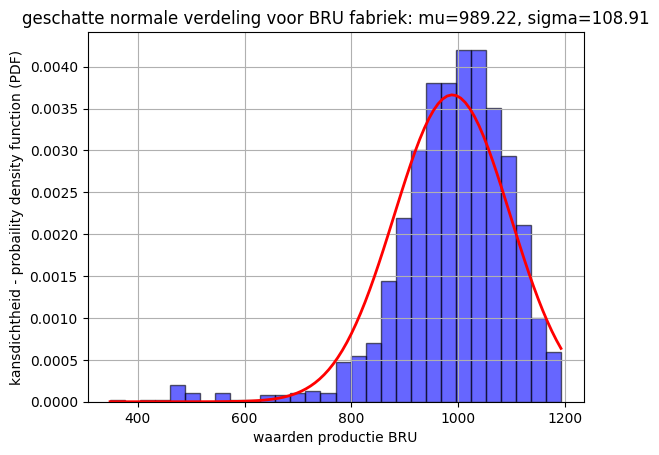

In [54]:
# analyse data voor BRU fabriek
print(f"Kans op BRU productiedag zonder productie =  {len(dagelijkse_productie_BRU_zonder_productie) / len(dagelijkse_productie_BRU)} ")

plotdata_BRU_met_productie = dagelijkse_productie_BRU_met_productie['production'].to_numpy()
mu_BRU, sigma_BRU = norm.fit(plotdata_BRU_met_productie)

# Maak een histogram van de gegevens
plt.hist(plotdata_BRU_met_productie, bins=30, density=True, alpha=0.6, color='b', edgecolor='black')

# Maak een PDF (probability density function) op basis van de geschatte parameters
x = np.linspace(min(plotdata_BRU_met_productie), max(plotdata_BRU_met_productie), 100)
pdf_BRU = norm.pdf(x, mu_BRU, sigma_BRU)

# Plot de PDF
plt.plot(x, pdf_BRU, 'r', linewidth=2)
plt.title(f'geschatte normale verdeling voor BRU fabriek: mu={mu_BRU:.2f}, sigma={sigma_BRU:.2f}')
plt.xlabel('waarden productie BRU')
plt.ylabel('kansdichtheid - probaility density function (PDF)')
plt.grid(True)
plt.show()

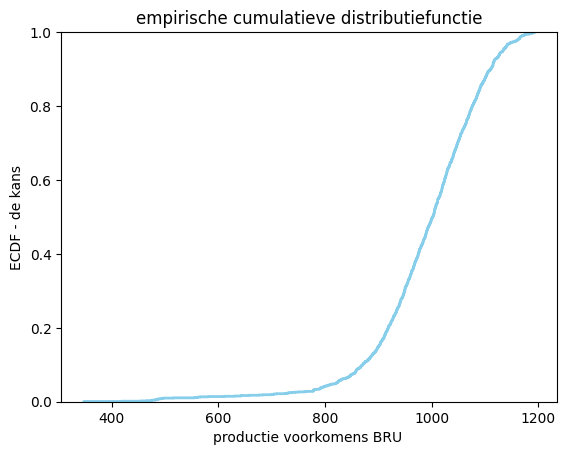

In [55]:
sns.ecdfplot(data=dagelijkse_productie_BRU_met_productie, x='production', color='skyblue', linewidth=2)

plt.xlabel('productie voorkomens BRU ')
plt.ylabel('ECDF - de kans')
plt.title('empirische cumulatieve distributiefunctie')

plt.show()

Kans op STO productiedag zonder productie =  0.07342657342657342 


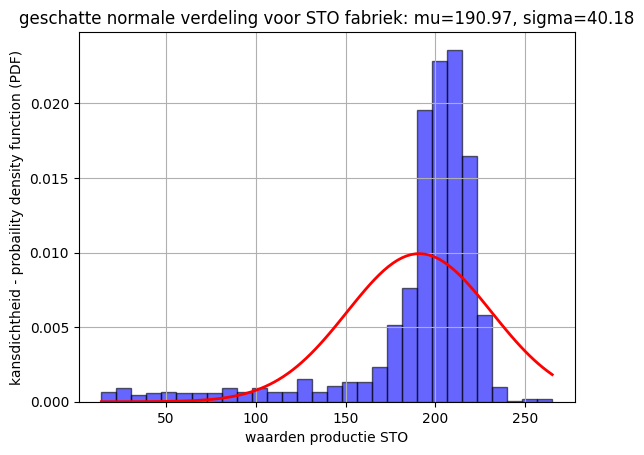

In [56]:
# analyse data voor STO fabriek
print(f"Kans op STO productiedag zonder productie =  {len(dagelijkse_productie_STO_zonder_productie) / len(dagelijkse_productie_STO)} ")

plotdata_STO_met_productie = dagelijkse_productie_STO_met_productie['production'].to_numpy()
mu_STO, sigma_STO = norm.fit(plotdata_STO_met_productie)

# Maak een histogram van de gegevens
plt.hist(plotdata_STO_met_productie, bins=30, density=True, alpha=0.6, color='b', edgecolor='black')

# Maak een PDF (probability density function) op basis van de geschatte parameters
x = np.linspace(min(plotdata_STO_met_productie), max(plotdata_STO_met_productie), 100)
pdf_STO = norm.pdf(x, mu_STO, sigma_STO)

# Plot de PDF
plt.plot(x, pdf_STO, 'r', linewidth=2)
plt.title(f'geschatte normale verdeling voor STO fabriek: mu={mu_STO:.2f}, sigma={sigma_STO:.2f}')
plt.xlabel('waarden productie STO')
plt.ylabel('kansdichtheid - probaility density function (PDF)')
plt.grid(True)
plt.show()

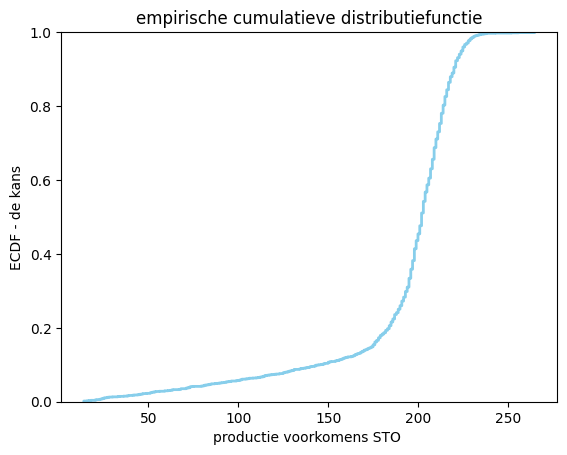

In [57]:
sns.ecdfplot(data=dagelijkse_productie_STO_met_productie, x='production', color='skyblue', linewidth=2)

plt.xlabel('productie voorkomens STO ')
plt.ylabel('ECDF - de kans')
plt.title('empirische cumulatieve distributiefunctie')

plt.show()

Kans op ALL productiedag zonder productie =  0.1257242178447277 


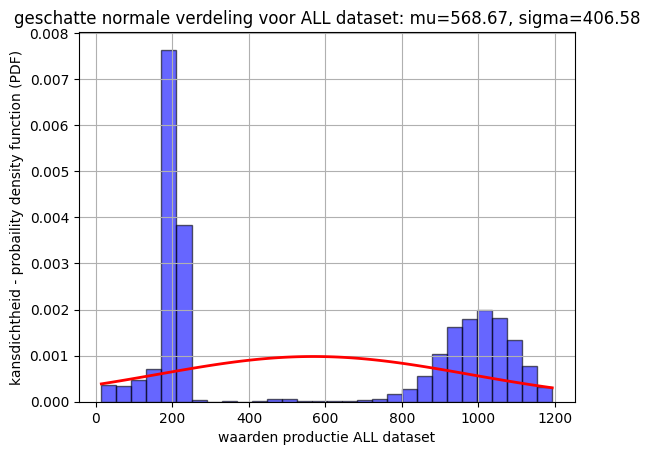

In [58]:
# analyse data voor ALL dataset (STO + BRU tesamen)
print(f"Kans op ALL productiedag zonder productie =  {len(dagelijkse_productie_ALL_zonder_productie) / len(dagelijkse_productie_ALL)} ")

plotdata_ALL_met_productie = dagelijkse_productie_ALL_met_productie['production'].to_numpy()
mu_ALL, sigma_ALL = norm.fit(plotdata_ALL_met_productie)

# Maak een histogram van de gegevens
plt.hist(plotdata_ALL_met_productie, bins=30, density=True, alpha=0.6, color='b', edgecolor='black')

# Maak een PDF (probability density function) op basis van de geschatte parameters
x = np.linspace(min(plotdata_ALL_met_productie), max(plotdata_ALL_met_productie), 100)
pdf_ALL = norm.pdf(x, mu_ALL, sigma_ALL)

# Plot de PDF
plt.plot(x, pdf_ALL, 'r', linewidth=2)
plt.title(f'geschatte normale verdeling voor ALL dataset: mu={mu_ALL:.2f}, sigma={sigma_ALL:.2f}')
plt.xlabel('waarden productie ALL dataset')
plt.ylabel('kansdichtheid - probaility density function (PDF)')
plt.grid(True)
plt.show()

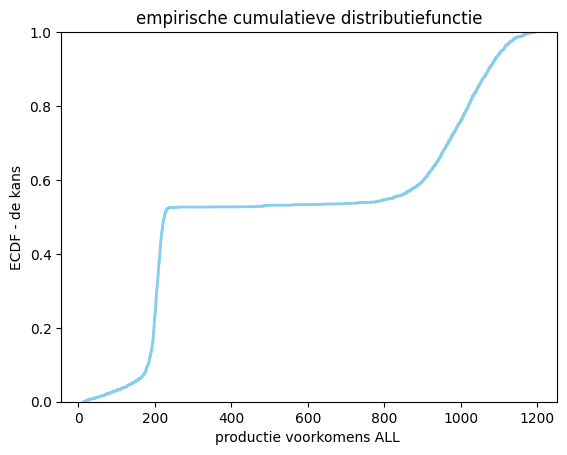

In [59]:
sns.ecdfplot(data=dagelijkse_productie_ALL_met_productie, x='production', color='skyblue', linewidth=2)

plt.xlabel('productie voorkomens ALL ')
plt.ylabel('ECDF - de kans')
plt.title('empirische cumulatieve distributiefunctie')

plt.show()

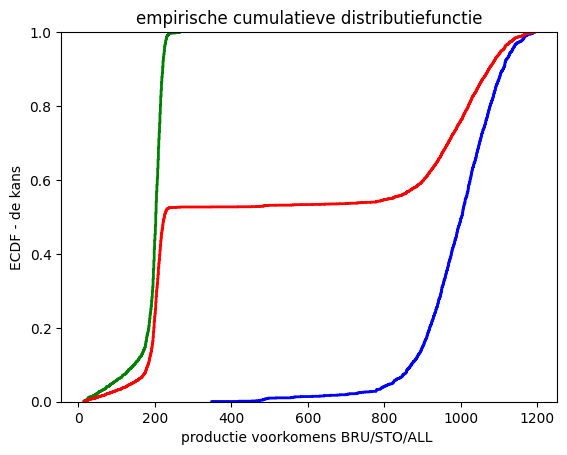

In [60]:
sns.ecdfplot(data=dagelijkse_productie_BRU_met_productie, x='production', color='b', linewidth=2)
sns.ecdfplot(data=dagelijkse_productie_STO_met_productie, x='production', color='g', linewidth=2)
sns.ecdfplot(data=dagelijkse_productie_ALL_met_productie, x='production', color='r', linewidth=2)

plt.xlabel('productie voorkomens BRU/STO/ALL ')
plt.ylabel('ECDF - de kans')
plt.title('empirische cumulatieve distributiefunctie')

plt.show()

In [61]:
# # voorbeeld analyse, fit data

# # Genereer voorbeeldgegevens (normaal verdeeld)
# np.random.seed(42)
# data = np.random.normal(loc=5, scale=2, size=1000)

# # Schat de parameters van de normale verdeling
# mu, sigma = norm.fit(data)

# # Maak een histogram van de gegevens
# plt.hist(data, bins=30, density=True, alpha=0.6, color='b', edgecolor='black')

# # Maak een PDF (probability density function) op basis van de geschatte parameters
# x = np.linspace(min(data), max(data), 100)
# pdf = norm.pdf(x, mu, sigma)

# # Plot de PDF
# plt.plot(x, pdf, 'r', linewidth=2)
# plt.title(f'Geschatte Normale Verdeling: mu={mu:.2f}, sigma={sigma:.2f}')
# plt.xlabel('te analyseren waarde')
# plt.ylabel('kansdichtheid')
# plt.grid(True)
# plt.show()

# G : uitvoeren van de simulatie

In [62]:
xx = np.linspace(0, 10 ** 4)
data = sim.simulatie(7)
Fxx = sim.cumulatieve_distributie_functie(xx)
# plt.plot(xx, Fxx)

In [67]:
data_points_BRU = np.random.normal(mu_BRU, sigma_BRU, len(dagelijkse_productie_BRU))
data_points_BRU_integer = np.round(data_points_BRU).astype(int)
data_points_STO = np.random.normal(mu_STO, sigma_STO, len(dagelijkse_productie_STO))
data_points_STO_integer = np.round(data_points_STO).astype(int)

The probability of observing a production quantity less than or equal to 250 is 0.5714285714285714
The probability of observing a production quantity less than or equal to 150 is 0.2857142857142857
The probability of observing a production quantity less than or equal to 100 is 0.14285714285714285
The probability of observing a production quantity less than or equal to 225 is 0.42857142857142855
The probability of observing a production quantity less than or equal to 300 is 0.7142857142857143
The probability of observing a production quantity less than or equal to 305 is 0.7142857142857143
The probability of observing a production quantity less than or equal to 349 is 0.7142857142857143
The probability of observing a production quantity less than or equal to 350 is 0.8571428571428571
The probability of observing a production quantity less than or equal to 400 is 1.0
The probability of observing a production quantity less than or equal to 475 is 1.0


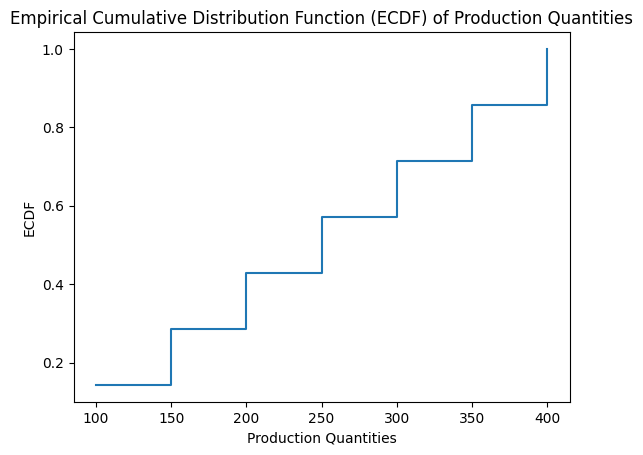

In [64]:
# Sample data: production quantities over a number of days
production_quantities = np.array([100, 150, 200, 250, 300, 350, 400])

# Calculate the ECDF
x = np.sort(production_quantities)
y = np.arange(1, len(x)+1) / len(x)

# Function to evaluate the ECDF at a given point
def ecdf(value):
    return y[x <= value].max()

# Predict the probability of a value
value = 250
print(f"The probability of observing a production quantity less than or equal to {value} is {ecdf(value)}")
value = 150
print(f"The probability of observing a production quantity less than or equal to {value} is {ecdf(value)}")
value = 100
print(f"The probability of observing a production quantity less than or equal to {value} is {ecdf(value)}")
value = 225
print(f"The probability of observing a production quantity less than or equal to {value} is {ecdf(value)}")
value = 300
print(f"The probability of observing a production quantity less than or equal to {value} is {ecdf(value)}")
value = 305
print(f"The probability of observing a production quantity less than or equal to {value} is {ecdf(value)}")
value = 349
print(f"The probability of observing a production quantity less than or equal to {value} is {ecdf(value)}")
value = 350
print(f"The probability of observing a production quantity less than or equal to {value} is {ecdf(value)}")
value = 400
print(f"The probability of observing a production quantity less than or equal to {value} is {ecdf(value)}")
value = 475
print(f"The probability of observing a production quantity less than or equal to {value} is {ecdf(value)}")


# Plot the ECDF
plt.step(x, y, where='post')
plt.xlabel('Production Quantities')
plt.ylabel('ECDF')
plt.title('Empirical Cumulative Distribution Function (ECDF) of Production Quantities')
plt.show()